# Political Alignment and Polarization

This is the second in a series of notebooks that make up a [case study in exploratory data analysis](https://allendowney.github.io/PoliticalAlignmentCaseStudy/).
This case study is part of the [*Elements of Data Science*](https://allendowney.github.io/ElementsOfDataScience/) curriculum.

This chapter and the next make up a case study that uses data from the General Social Survey (GSS) to explore political beliefs and political alignment (conservative, moderate, or liberal) in the United States.

In this chapter, we:

1. Compare the distributions of political alignment from 1974 and 2021.

2. Plot the mean and standard deviation of responses over time as a way of quantifying shifts in political alignment and polarization.

3. Use local regression to plot a smooth line through noisy data.

4. Use cross tabulation to compute the fraction of respondents in each category over time.

5. Plot the results using a custom color palette.

As an exercise, you will look at changes in political party affiliation over the same period.

In the next chapter, we'll use the same dataset to explore the relationship between political alignment and other attitudes and beliefs.

The following cell installs the `empiricaldist` library if necessary.

In [1]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

If everything we need is installed, the following cell should run without error.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from empiricaldist import Pmf

## Loading the data

In the previous notebook, we downloaded GSS data, loaded and cleaned it, resampled it to correct for stratified sampling, and then saved the data in an HDF file, which is much faster to load.  In this and the following notebooks, we'll download the HDF file and load it.

The following cell downloads the file if necessary.

In [3]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download(
    "https://github.com/AllenDowney/PoliticalAlignmentCaseStudy/raw/master/gss_pacs_resampled.hdf"
)

In the the repository for this book, you'll find an HDF file that contains the GSS data, which I have cleaned and resampled to correct for stratified sampling.
The file that contains three resamplings;  we'll use the first, `gss0`, to get started.

In [4]:
datafile = "gss_pacs_resampled.hdf"
gss = pd.read_hdf(datafile, "gss0")
gss.shape

(68846, 204)

## Political Alignment

The people surveyed as part of the GSS were asked about their "political alignment", which is where they place themselves on a spectrum from liberal to conservative.

The variable `polviews` contains responses to the following question (see <https://gssdataexplorer.norc.org/variables/178/vshow>):

> We hear a lot of talk these days about liberals and conservatives. 
I'm going to show you a seven-point scale on which the political views that people might hold are arranged from extremely liberal--point 1--to extremely conservative--point 7. Where would you place yourself on this scale?

Here are the valid responses:

```
1	Extremely liberal
2	Liberal
3	Slightly liberal
4	Moderate
5	Slightly conservative
6	Conservative
7	Extremely conservative
```

To see how the responses have changed over time, we'll inspect them at the beginning and end of the observation period.
First we'll select the column.

In [5]:
polviews = gss["polviews"]

Then we can compute a Boolean Series that's `True` for responses from 1974.

In [6]:
year74 = gss["year"] == 1974

Now we can select the responses from 1974.

In [7]:
polviews74 = polviews[year74]

We'll use the following function to count the number of times each response occurs.

In [8]:
def values(series):
    """Count the values and sort.

    series: pd.Series

    returns: series mapping from values to frequencies
    """
    return series.value_counts().sort_index()

Here are the responses from 1974.

In [9]:
values(polviews74)

1.0     31
2.0    201
3.0    211
4.0    538
5.0    223
6.0    181
7.0     30
Name: polviews, dtype: int64

And here are the responses from 2021.

In [10]:
year21 = gss["year"] == 2021
polviews21 = polviews[year21]
values(polviews21)

1.0     212
2.0     577
3.0     427
4.0    1506
5.0     480
6.0     569
7.0     181
Name: polviews, dtype: int64

Looking at a table of counts, we can get a sense of what the distribution looks like, but in the next section we'll get a better sense by plotting it.

## Visualizing Distributions

To visualize these distributions, we'll use a Probability Mass Function (PMF), which is similar to a histogram, but there are two differences:

* In a histogram, values are often put in bins, with more than one value in each bin. In a PMF each value gets its own bin.

* A histogram computes a count, that is, how many times each value appears; a PMF computes a probability, that is, what fraction of the time each value appears. 

We'll use the `Pmf` class from `empiricaldist` to compute a PMF.

In [11]:
from empiricaldist import Pmf

pmf74 = Pmf.from_seq(polviews74)
pmf74

,probs
1.0,0.021908
2.0,0.142049
3.0,0.149117
4.0,0.380212
5.0,0.157597
6.0,0.127915
7.0,0.021201


The following cell defines a function I use to decorate the axes in plots.

In [12]:
def decorate(**options):
    """Decorate the current axes.

    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')

    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    ax = plt.gca()
    ax.set(**options)
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels)

Here's the distribution from 1974:

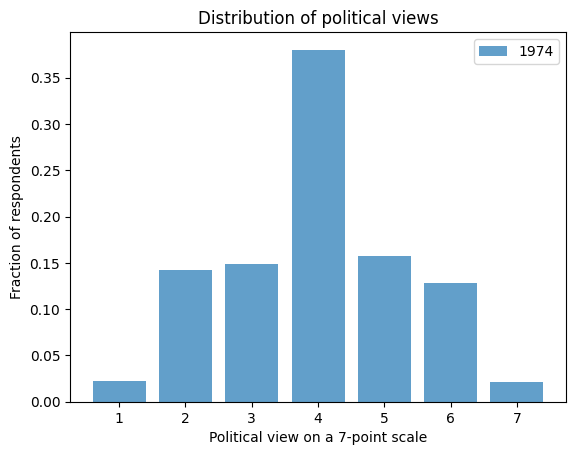

In [13]:
pmf74.bar(label="1974", color="C0", alpha=0.7)

decorate(
    xlabel="Political view on a 7-point scale",
    ylabel="Fraction of respondents",
    title="Distribution of political views",
)

And from 2021:

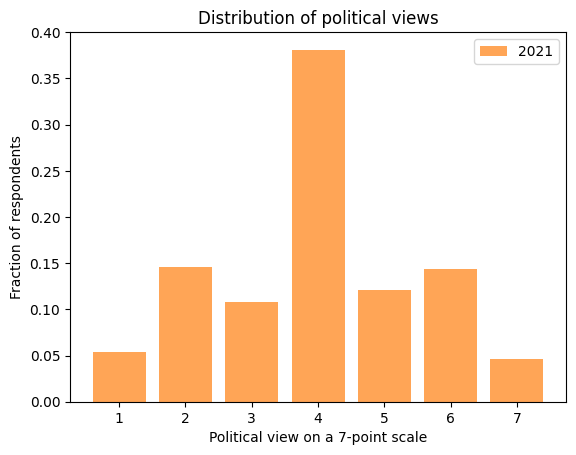

In [14]:
pmf21 = Pmf.from_seq(polviews21)
pmf21.bar(label="2021", color="C1", alpha=0.7)

decorate(
    xlabel="Political view on a 7-point scale",
    ylabel="Fraction of respondents",
    title="Distribution of political views",
)

In both cases, the most common response is `4`, which is the code for "moderate".  Few respondents describe themselves as "extremely" liberal or conservative.
So maybe we're not so polarized after all.

To make it easier to compare the distributions, I'll plot them side by side.  

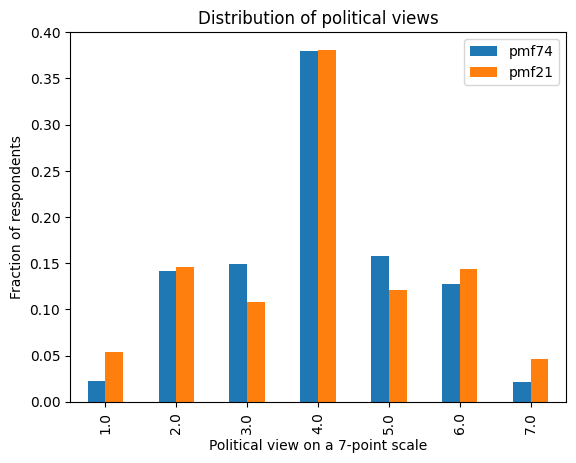

In [15]:
d = dict(pmf74=pmf74, pmf21=pmf21)

df = pd.DataFrame(d)
df.plot(kind="bar")

decorate(
    xlabel="Political view on a 7-point scale",
    ylabel="Fraction of respondents",
    title="Distribution of political views",
)

Now we can see the changes in the distribution more clearly.  It looks like the number of people at the extremes (1 and 7) has increased, and the fraction of slightly liberal (3) and slightly conservative (5) has decreased.

**Exercise:** To summarize these changes, we can compare the mean and standard deviation of `polviews` in 1974 and 2021.

The mean of the responses measures the balance of people in the population with liberal or conservative leanings.  If the mean increases over time, that might indicate a shift in the population toward conservatism.

The standard deviation measures the dispersion of views in the population; if it increases over time, that might indicate an increase in polarization.

Compute the mean and standard deviation of `polviews74` and `polviews21`.

What do they indicate about changes over this interval?

In [16]:
# Solution

polviews74.mean(), polviews74.std()

(3.9780918727915195, 1.3324162225592249)

In [17]:
# Solution

polviews21.mean(), polviews21.std()

(3.98582995951417, 1.5115522818003158)

In [18]:
# Solution

# The mean has barely changed, which indicates no
# net shift toward liberal or conservate identity.

# The standard deviation has increased,
# which suggests increased polarization.

## Plotting a Time Series

At this point we have looked at the endpoints, 1974 and 2021, but we don't know what happened in between.
To see how the distribution changed over time, we can group by year and compute the mean of `polviews` during each year.
We can use `groupby` to group the respondents by year.

In [19]:
gss_by_year = gss.groupby("year")
gss_by_year

The result is a `DataFrameGroupBy` object that represents a collection of groups.

We can loop through the groups and display the number of respondents in each:

In [20]:
for year, group in gss_by_year:
    print(year, len(group))

1972 1613
1973 1504
1974 1484
1975 1490
1976 1499
1977 1530
1978 1532
1980 1468
1982 1860
1983 1599
1984 1473
1985 1534
1986 1470
1987 1819
1988 1481
1989 1537
1990 1372
1991 1517
1993 1606
1994 2992
1996 2904
1998 2832
2000 2817
2002 2765
2004 2812
2006 4510
2008 2023
2010 2044
2012 1974
2014 2538
2016 2867
2018 2348
2021 4032


In many ways the `DataFrameGroupBy` behaves like a `DataFrame`.  We can use the bracket operator to select a column: 

In [21]:
polviews_by_year = gss_by_year["polviews"]
polviews_by_year

A column from a `DataFrameGroupBy` is a `SeriesGroupBy`.  If we invoke `mean` on it, the results is a series that contains the mean of `polviews` for each year of the survey.

In [22]:
mean_series = polviews_by_year.mean()

And here's what it looks like.

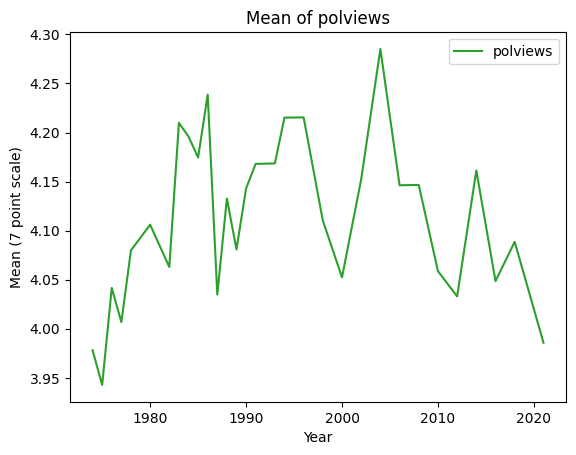

In [23]:
mean_series.plot(color="C2", label="polviews")
decorate(xlabel="Year", ylabel="Mean (7 point scale)", title="Mean of polviews")

It looks like the mean increased between 1974 and 2000, decreased since then, and ended up almost where it started.
The difference between the highest and lowest points is only 0.3 points on a 7-point scale, which is a modest effect. 

In [24]:
mean_series.max() - mean_series.min()

0.34240143126104083

**Exercise:** The standard deviation quantifies the spread of the distribution, which is one way to measure polarization.
Plot standard deviation of `polviews` for each year of the survey from 1972 to 2021.
Does it show evidence of increasing polarization?

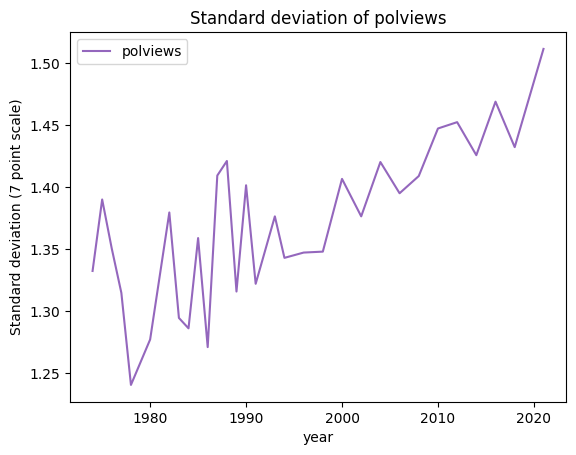

In [25]:
# Solution

std_series = gss_by_year["polviews"].std()
std_series.plot(color="C4", label="polviews")
decorate(
    ylabel="Standard deviation (7 point scale)", title="Standard deviation of polviews"
)

In [26]:
# Solution

# The standard deviation has increased consistently over the entire interval.
# But the difference between the highest and lowest points is small.
# So if polarization is increasing, it is not a recent phenomenon, and it
# is not changing quickly.

## Smoothing the Curve

In the previous section we plotted mean and standard deviation of `polviews` over time.
In both plots, the values are highly variable from year to year.
We can use **local regression** to compute a smooth line through these data points.  

The following function takes a Pandas Series and uses an algorithm called LOWESS to compute a smooth line.
LOWESS stands for "locally weighted scatterplot smoothing".

In [27]:
from statsmodels.nonparametric.smoothers_lowess import lowess


def make_lowess(series):
    """Use LOWESS to compute a smooth line.

    series: pd.Series

    returns: pd.Series
    """
    y = series.values
    x = series.index.values

    smooth = lowess(y, x)
    index, data = np.transpose(smooth)

    return pd.Series(data, index=index)

We'll use the following function to plot data points and the smoothed line.

In [28]:
def plot_series_lowess(series, color):
    """Plots a series of data points and a smooth line.

    series: pd.Series
    color: string or tuple
    """
    series.plot(linewidth=0, marker="o", color=color, alpha=0.5)
    smooth = make_lowess(series)
    smooth.plot(label="", color=color)

The following figure shows the mean of `polviews` and a smooth line.

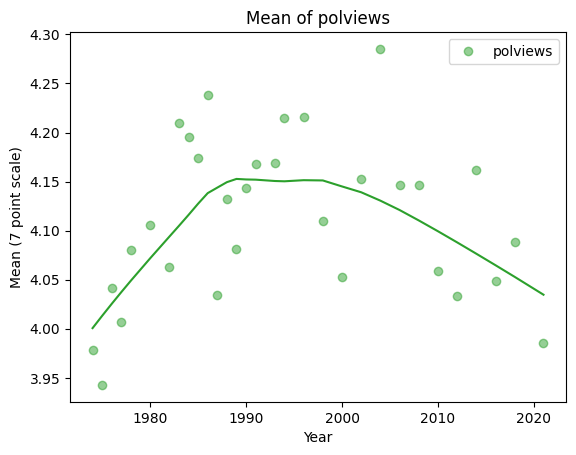

In [29]:
mean_series = gss_by_year["polviews"].mean()
plot_series_lowess(mean_series, "C2")
decorate(ylabel="Mean (7 point scale)", title="Mean of polviews", xlabel="Year")

One reason the PMFs for 1974 and 2021 did not look very different is that the mean seems to have gone up (more conservative) and then down again (more liberal).
Generally, it looks like the U.S. has been trending toward liberal for the last 20 years, or more, at least in the sense of how people describe themselves.

**Exercise:** Use `plot_series_lowess` to plot the standard deviation of `polviews` with a smooth line.

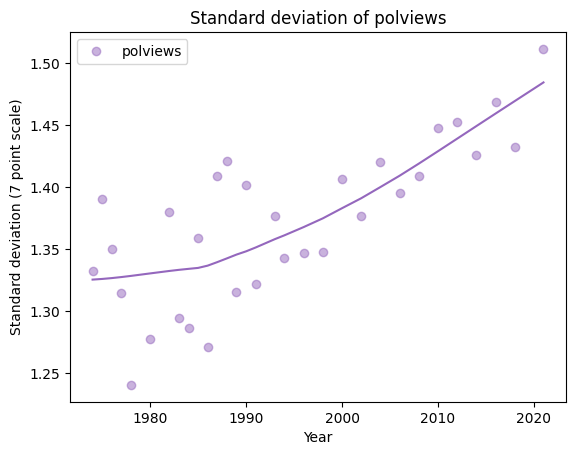

In [30]:
# Solution

std_series = gss_by_year["polviews"].std()
plot_series_lowess(std_series, color="C4")
decorate(
    ylabel="Standard deviation (7 point scale)",
    title="Standard deviation of polviews",
    xlabel="Year",
)

## Cross Tabulation

In the previous sections, we treated `polviews` as a numerical quantity, so we were able to compute means and standard deviations.
But the responses are really categorical, which means that each value represents a discrete category, like "liberal" or "conservative".
In this section, we'll treat `polviews` as a categorical variable.  Specifically, we'll compute the number of respondents in each category for each year, and plot changes over time.

Pandas provides a function called `crosstab` that computes a **cross tabulation**, which is like a two-dimensional PMF.
It takes two `Series` objects as arguments and returns a `DataFrame`.

In [31]:
year = gss["year"]
column = gss["polviews"]

xtab = pd.crosstab(year, column)

Here are the first few lines from the result.

In [32]:
xtab.head()

polviews,1.0,2.0,3.0,4.0,5.0,6.0,7.0
year,,,,,,,
1974,31,201,211,538,223,181,30
1975,56,184,207,540,204,162,45
1976,31,198,175,564,209,206,34
1977,37,181,214,594,243,164,42
1978,21,140,255,559,265,187,25


It contains one row for each value of `year` and one column for each value of `polviews`.  Reading the first row, we see that in 1974, 31 people gave response 1, "extremely liberal", 201 people gave response 2, "liberal", and so on.

The number of respondents varies from year to year, so we need to normalize the results, which means computing for each year the *fraction* of respondents in each category, rather than the count.

`crosstab` takes an optional argument that normalizes each row.

In [33]:
xtab_norm = pd.crosstab(year, column, normalize="index")

Here's what that looks like for the 7-point scale.

In [34]:
xtab_norm.head()

polviews,1.0,2.0,3.0,4.0,5.0,6.0,7.0
year,,,,,,,
1974,0.021908,0.142049,0.149117,0.380212,0.157597,0.127915,0.021201
1975,0.040057,0.131617,0.148069,0.386266,0.145923,0.115880,0.032189
1976,0.021877,0.139732,0.123500,0.398024,0.147495,0.145378,0.023994
1977,0.025085,0.122712,0.145085,0.402712,0.164746,0.111186,0.028475
1978,0.014463,0.096419,0.175620,0.384986,0.182507,0.128788,0.017218


Looking at the numbers in the table, it's hard to see what's going on.
In the next section, we'll plot the results.

To make the results easier to interpret, I'm going to replace the numeric codes 1-7 with strings.  First I'll make a dictionary that maps from numbers to strings:

In [35]:
# recode the 7 point scale with words
d7 = {
    1: "Extremely liberal",
    2: "Liberal",
    3: "Slightly liberal",
    4: "Moderate",
    5: "Slightly conservative",
    6: "Conservative",
    7: "Extremely conservative",
}

Then we can use the `replace` function like this:

In [36]:
polviews7 = gss["polviews"].replace(d7)

We can use `values` to confirm that the values in `polviews7` are strings.

In [37]:
values(polviews7)

Conservative               9064
Extremely conservative     1951
Extremely liberal          1911
Liberal                    6876
Moderate                  22950
Slightly conservative      9344
Slightly liberal           7408
Name: polviews, dtype: int64

If we make the cross tabulation again, we can see that the column names are strings.

In [38]:
xtab_norm = pd.crosstab(year, polviews7, normalize="index")
xtab_norm.head()

polviews,Conservative,Extremely conservative,Extremely liberal,Liberal,Moderate,Slightly conservative,Slightly liberal
year,,,,,,,
1974,0.127915,0.021201,0.021908,0.142049,0.380212,0.157597,0.149117
1975,0.115880,0.032189,0.040057,0.131617,0.386266,0.145923,0.148069
1976,0.145378,0.023994,0.021877,0.139732,0.398024,0.147495,0.123500
1977,0.111186,0.028475,0.025085,0.122712,0.402712,0.164746,0.145085
1978,0.128788,0.017218,0.014463,0.096419,0.384986,0.182507,0.175620


We are almost ready to plot the results, but first we need some colors.

## Color Palettes

Seaborn provides a variety of color palettes,  [which you can read about here](https://seaborn.pydata.org/tutorial/color_palettes.html).

To represent political views, I'll use a diverging palette from blue to red.

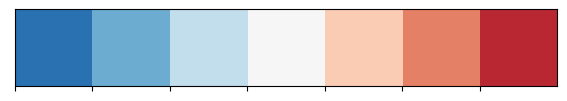

In [39]:
palette = sns.color_palette("RdBu_r", 7)
sns.palplot(palette)

Here's the modified diverging palette  with purple in the middle.

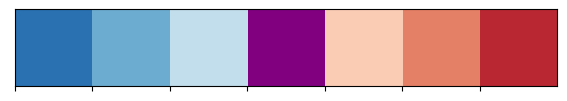

In [40]:
palette[3] = "purple"
sns.palplot(palette)

A feature of this color map is that the colors are meaningful, at least in countries that use blue, purple, and red for these points on the political spectrum.
A drawback of this color map is that some some of the colors are indistinguishable to people who are [color blind](https://davidmathlogic.com/colorblind).

Now I'll make a dictionary that maps from the responses to the corresponding colors.

In [41]:
columns = [
    "Extremely liberal",
    "Liberal",
    "Slightly liberal",
    "Moderate",
    "Slightly conservative",
    "Conservative",
    "Extremely conservative",
]

In [42]:
color_map = dict(zip(columns, palette))

for key, value in color_map.items():
    print(key, value)

Extremely liberal (0.16339869281045757, 0.44498269896193776, 0.6975009611687812)
Liberal (0.4206843521722416, 0.6764321414840447, 0.8186851211072664)
Slightly liberal (0.7614763552479817, 0.8685121107266438, 0.924567474048443)
Moderate purple
Slightly conservative (0.9824682814302191, 0.8006920415224913, 0.7061130334486736)
Conservative (0.8945790080738177, 0.5038062283737024, 0.39976931949250283)
Extremely conservative (0.7284890426758939, 0.15501730103806227, 0.1973856209150327)


## Plotting a Cross Tabulation

To see how the fraction of people with each political alignment has changed over time,
we'll use `plot_series_lowess` to plot the columns from `xtab_norm`.

Here are the 7 categories plotted as a function of time.
The `bbox_to_anchor` argument passed to `plt.legend` puts the legend outside the axes of the figure.

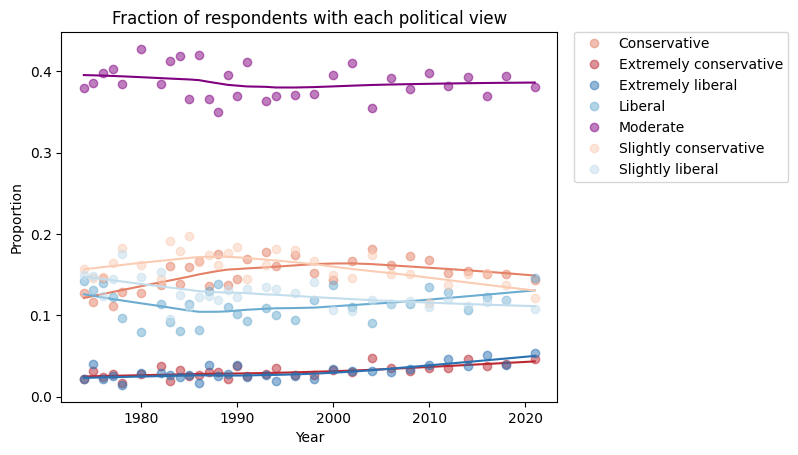

In [43]:
for name, column in xtab_norm.items():
    plot_series_lowess(column, color_map[name])

decorate(
    xlabel="Year",
    ylabel="Proportion",
    title="Fraction of respondents with each political view",
)

plt.legend(bbox_to_anchor=(1.02, 1.02))
None

This way of looking at the results suggests that changes in political alignment during this period have generally been slow and small.
The fraction of self-described moderates has not changed substantially.
The fraction of conservatives increased, but seems to be decreasing now; the number of liberals seems to be increasing.

The fraction of people at the extremes has increased, but it is hard to see clearly in this figure.
We can get a better view by plotting just the extremes.

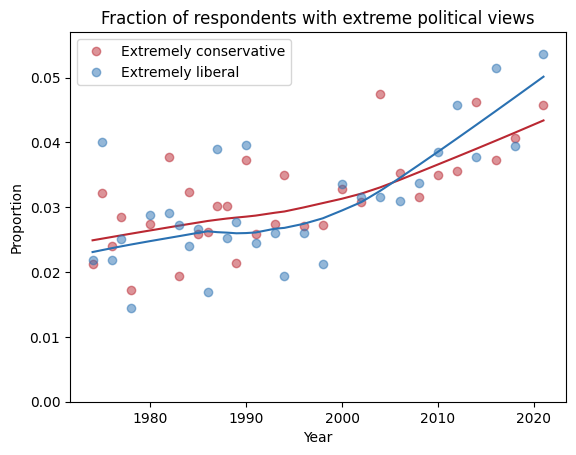

In [44]:
selected_columns = ["Extremely liberal", "Extremely conservative"]

for name, column in xtab_norm.items():
    if name not in selected_columns:
        continue
    plot_series_lowess(column, color_map[name])

decorate(
    xlabel="Year",
    ylabel="Proportion",
    ylim=[0, 0.057],
    title="Fraction of respondents with extreme political views",
)

I used `ylim` to set the limits of the y-axis so it starts at zero, to avoid making the changes seem bigger than they are.

This figure shows that the fraction of people who describe themselves as "extreme" has increased from about 2.5% to about 5%.
In relative terms, that's a big increase.  But in absolute terms these tails of the distribution are still small.

**Exercise:** Let's do a similar analysis with `partyid`, which encodes responses to the question:

>Generally speaking, do you usually think of yourself as a Republican, Democrat, Independent, or what?

The valid responses are:

```
0	Strong democrat
1	Not str democrat
2	Ind,near dem
3	Independent
4	Ind,near rep
5	Not str republican
6	Strong republican
7	Other party
```

You can read the codebook for `partyid`  at <https://gssdataexplorer.norc.org/variables/141/vshow>.
In the notebook for this chapter, there are some suggestions to get you started.

Here are the steps I suggest:

1) If you have not already saved this notebook, you should do that first.  If you are running on Colab, select "Save a copy in Drive" from the File menu.

2) Now, before you modify this notebook, make *another* copy and give it an appropriate name.

3) Search and replace `polviews` with `partyid` (use "Edit->Find and replace").

4) Run the notebook from the beginning and see what other changes you have to make.

You will have to make changes in `d7` and `columns`.  Otherwise you might get a message like 

`TypeError: '<' not supported between instances of 'float' and 'str'`

Also, you might have to drop "Other party" or change the color palette.

And you should change the titles of the figures.


What changes in party affiliation do you see over the last 50 years?  Are things going in the directions you expected?

## Summary

This chapter uses some tools we have seen before, like the `Pmf` object and the `groupby` function.
And it introduces two new tools: local regression for computing a smooth curve through noisy data, and cross tabulation for counting the number of people, or fraction, in each group over time.

Now that we have a sense of how political alignment as changed, in the next chapter we'll explore the relationship between political alignment and other beliefs and attitudes.

Political Alignment Case Study

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)